In [1]:
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import scipy.io, cv2

# Find images path
scene_paths = glob('../Dataset_CNN/*/')

# Fulfill data
X_ = []
y_ = []
Xtest_ = []
ytest_ = []

max_values_y = []
normalize = True

for scene in scene_paths:
    print(scene)
    windows_path = glob(scene + '*')
    
    for window in windows_path:
        images_ref_path = glob(window + '/w_*.jpg')
        NLF_path = window + '/NLF_filtered.mat'
        
        mat = scipy.io.loadmat(NLF_path)
        NLF = (mat["NLF_step_filt"][0])
        NLF[np.isnan(NLF)] = 0
        
        max_values_y.append(max(NLF[0:64]))
        
        for img_ref in images_ref_path[0:5]:
            img = plt.imread(img_ref)
            
            if normalize:
                img = np.float16(img/255)
            
            X_.append(img)
            y_.append(NLF[0:64]) #*100
            
        for img_ref in images_ref_path[8:9]:
            img = plt.imread(img_ref)
            
            if normalize:
                img = np.float16(img/255)
            
            Xtest_.append(img)
            ytest_.append(NLF[0:64])
            
        

../Dataset_CNN/Scene_30/
../Dataset_CNN/Scene_35/
../Dataset_CNN/Scene_36/
../Dataset_CNN/Scene_21/
../Dataset_CNN/Scene_33/
../Dataset_CNN/Scene_07/
../Dataset_CNN/Scene_32/
../Dataset_CNN/Scene_34/
../Dataset_CNN/Scene_11/
../Dataset_CNN/Scene_10/
../Dataset_CNN/Scene_13/
../Dataset_CNN/Scene_31/
../Dataset_CNN/Scene_08/
../Dataset_CNN/Scene_23/
../Dataset_CNN/Scene_15/
../Dataset_CNN/Scene_24/
../Dataset_CNN/Scene_19/
../Dataset_CNN/Scene_22/
../Dataset_CNN/Scene_20/
../Dataset_CNN/Scene_12/
../Dataset_CNN/Scene_09/
../Dataset_CNN/Scene_26/
../Dataset_CNN/Scene_06/
../Dataset_CNN/Scene_28/
../Dataset_CNN/Scene_18/
../Dataset_CNN/Scene_29/
../Dataset_CNN/Scene_17/
../Dataset_CNN/Scene_27/
../Dataset_CNN/Scene_16/
../Dataset_CNN/Scene_14/
../Dataset_CNN/Scene_25/
../Dataset_CNN/Scene_05/


In [3]:
maxmax_y_ = max(max_values_y)
print(y_[0][60])
for y in y_:
    y = y/maxmax_y_
    
print(y_[0][60])

0.022705713591474764
0.022705713591474764


In [4]:
X_ = np.asarray(X_)
y_ = np.asarray(y_)

Xtest_ = np.asarray(Xtest_)
ytest_ = np.asarray(ytest_)


In [5]:
print(np.shape(X_))
print(np.shape(y_))
print()
print(np.shape(Xtest_))
print(np.shape(ytest_))

(34560, 256, 256, 3)
(34560, 64)

(6912, 256, 256, 3)
(6912, 64)


### Crear modelo

In [6]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Reshape, LeakyReLU
from keras.layers import concatenate, AveragePooling2D, Activation, BatchNormalization
from keras.models import Model
from SpatialPyramidPooling import SpatialPyramidPooling
import keras
# First, define the vision modules
input_imgs = Input(shape=(256, 256, 3))

# Model
def get_model_column(ks_1, ks_2,p_):
    x = Conv2D(64, kernel_size=(ks_1,ks_1), strides = 2, activation=None, 
               bias_initializer='ones', kernel_initializer = 'glorot_normal')(input_imgs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None, 
               bias_initializer='ones', kernel_initializer = 'glorot_normal')(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D((2, 2))(x) # pool2_a
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None,  
               bias_initializer='ones', kernel_initializer = 'glorot_normal')(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64, kernel_size=(ks_2,ks_2), activation=None,  
               bias_initializer='ones', kernel_initializer = 'glorot_normal')(x) # conv2_a
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    #out = keras.layers.ZeroPadding2D(padding=((p_, 0), (0, p_)), data_format=None)(x)
    out = Flatten()(x)
    return out

vision_model1 = Model(input_imgs, get_model_column(5, 3, 0))
vision_model2 = Model(input_imgs, get_model_column(7, 5, 5))
vision_model3 = Model(input_imgs, get_model_column(9, 7, 10))

# Then define the input-apart model
input_a = Input(shape=(256, 256, 3))
input_b = Input(shape=(256, 256, 3)) #shape=(300, 300, 3))
input_c = Input(shape=(256, 256, 3)) #shape=(340, 340, 3))

# The vision model will be shared, weights and all
out_a = vision_model1(input_a)
out_b = vision_model2(input_b)
out_c = vision_model3(input_c)

concatenated = concatenate([out_a, out_b, out_c],axis=1)
#out = Dense(1, activation='sigmoid')(concatenated)
#merge_abc = SpatialPyramidPooling([1, 2, 4])(concatenated)
merge_abc = Dense(2048, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(concatenated)
#merge_abc = Dense(256*3, activation='relu')(merge_abc)
merge_abc = Dense(64, activation='relu',
                  bias_initializer='ones', kernel_initializer = 'glorot_normal')(merge_abc)
#merge_abc = LeakyReLU(alpha = 0.1)(merge_abc)

model_abc = Model([input_a, input_b, input_c], merge_abc)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


### Training

In [7]:
from keras import optimizers
from keras import losses

sgd = optimizers.SGD(lr=0.0001, decay=0.0001, momentum=0.9, nesterov=True)

# compile model (abc)
model_abc.compile(optimizer= sgd, loss='mse')
#model_abc.compile(optimizer= sgd, loss=losses.kullback_leibler_divergence)


In [6]:
'''# Make model_a non trainable
model_abc.layers[3].trainable = False
model_abc.layers[4].trainable = False
#model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=10, validation_split=0.1, shuffle=True)
model_abc.fit(x=[X_,X_,X_], y=y_, validation_data=([Xtest_,Xtest_,Xtest_], ytest_),batch_size=64, epochs=30, shuffle=True)

# Make model_a non trainable
model_abc.layers[3].trainable = False
model_abc.layers[4].trainable = True
model_abc.layers[5].trainable = False
#model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=10, validation_split=0.1, shuffle=True)
model_abc.fit(x=[X_,X_,X_], y=y_, validation_data=([Xtest_,Xtest_,Xtest_], ytest_),batch_size=64, epochs=30, shuffle=True)

# Make model_a non trainable
model_abc.layers[3].trainable = True
model_abc.layers[4].trainable = False
model_abc.layers[5].trainable = False
#model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=10, validation_split=0.1, shuffle=True)'''
#model_abc.fit(x=[X_,X_,X_], y=y_, validation_data=([Xtest_,Xtest_,Xtest_], ytest_),batch_size=64, epochs=30, shuffle=True)


'# Make model_a non trainable\nmodel_abc.layers[3].trainable = False\nmodel_abc.layers[4].trainable = False\n#model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=10, validation_split=0.1, shuffle=True)\nmodel_abc.fit(x=[X_,X_,X_], y=y_, validation_data=([Xtest_,Xtest_,Xtest_], ytest_),batch_size=64, epochs=30, shuffle=True)\n\n# Make model_a non trainable\nmodel_abc.layers[3].trainable = False\nmodel_abc.layers[4].trainable = True\nmodel_abc.layers[5].trainable = False\n#model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=10, validation_split=0.1, shuffle=True)\nmodel_abc.fit(x=[X_,X_,X_], y=y_, validation_data=([Xtest_,Xtest_,Xtest_], ytest_),batch_size=64, epochs=30, shuffle=True)\n\n# Make model_a non trainable\nmodel_abc.layers[3].trainable = True\nmodel_abc.layers[4].trainable = False\nmodel_abc.layers[5].trainable = False\n#model_abc.fit(x=[X_,X_,X_], y=y_, batch_size=64, epochs=10, validation_split=0.1, shuffle=True)'

In [8]:
import matplotlib.pyplot as plt

def pred_mc_net(model, ii):
    
    y_pred = np.transpose(model.predict([[X_[ii]],[X_[ii]],[X_[ii]]]))

    fig, ax = plt.subplots()
    y_pred[y_pred < 0] = 0
    ax.plot(y_pred,'r')

    ax.set(xlabel='intensity', ylabel='std',
           title='pred nlf')
    plt.show()

    fig, ax = plt.subplots()
    ax.plot(y_[ii],'r')

    ax.set(xlabel='intensity', ylabel='std',
           title='test nlf')
    plt.show()
    

In [9]:
count = 0
hist_loss = []
hist_val_loss = []

In [ ]:
# Variables for convergence checking
converged = False

print()
std_thold = 0.001

while not converged:

    print('Iteration ' + str(count+1))

    # Training the model
    history = model_abc.fit(x=[X_,X_,X_], y=y_, validation_data=([Xtest_,Xtest_,Xtest_], ytest_), 
                            epochs=1, shuffle=True, batch_size = 64)
            
    pred_mc_net(model_abc, 0)
        
    count += 1
    mean_samples = 6

    # Checking the convergence of the model using the standard deviation of the accuracy for some epochs
    hist_loss.extend(history.history["loss"])
    hist_val_loss.extend(history.history["val_loss"])    
    
    used_hist_val_loss = hist_val_loss[max(0,len(hist_val_loss)-mean_samples):len(hist_val_loss)]

    if len(used_hist_val_loss) >= mean_samples:
        mean_acc = float(sum(np.asarray(used_hist_val_loss)))/float(len(used_hist_val_loss))
        std_cutre = float(sum(np.abs(np.asarray(used_hist_val_loss)-mean_acc)))/float(len(used_hist_val_loss))

        print("STD OF " + str(len(used_hist_val_loss)) + ' SAMPLES: '),
        print(std_cutre)

        if std_cutre < std_thold or count > 20:
            converged = True
            
    else:
        # converged = True # Useful for testing
        print("Not enough samples to compute the STD :(")

    print('\n')


Iteration 1
Instructions for updating:
Use tf.cast instead.
Train on 34560 samples, validate on 6912 samples
Epoch 1/1
34496/34560 [============================>.] - ETA: 0s - loss: 0.0263

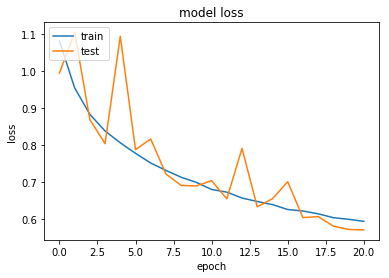

In [9]:
# summarize history for loss
plt.plot(hist_loss)
plt.plot(hist_val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

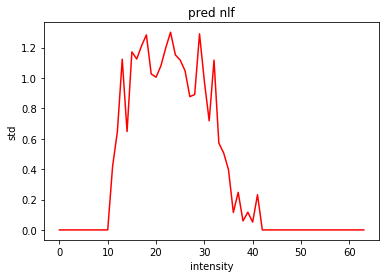

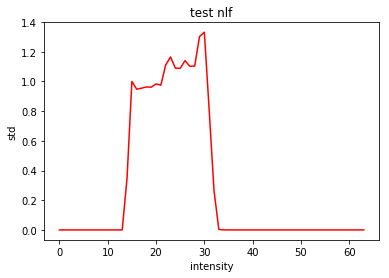

In [13]:
pred_mc_net(model_abc,30008)

In [5]:
vision_model1.summary()
model_abc.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 64)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
__________

In [14]:
# serialize model to JSON
model_json = model_abc.to_json()
with open("models/model_0105_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_abc.save_weights("models/model_0105_2.h5")
print("Saved model to disk")

Saved model to disk


In [1]:
from keras.models import model_from_json
# load model
json_file = open("models/model_0105.json", "r")
loaded_model_json = json_file.read()
json_file.close()
model_abc = model_from_json(loaded_model_json)

model_abc.load_weights("models/model_0105.h5")
print('loaded model')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
loaded model


In [ ]:
from keras.utils import plot_model

plot_model(model_abc, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import scipy.io


scene = 'Scene_21'
nlf_path = '../Dataset_Final/NLFs/NLF_' + scene + '.mat'
mat = scipy.io.loadmat('../Dataset_Final/NLFs/NLF_' + scene + '.mat')
NLF = mat["NLF"][0]
NLF_r = np.nan_to_num(NLF[0:256])

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y,b,a

order = 5
fs = 30    # sample rate, Hz
cutoff = 2
y,b,a = butter_lowpass_filter(NLF_r, cutoff, fs, order)

# Plot the frequency response.
w, h = freqz(b, a, worN=8000)

plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

fig, ax = plt.subplots()
ax.plot(y,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf filtered')
plt.show()

fig, ax = plt.subplots()
ax.plot(NLF_r,'r')

ax.set(xlabel='intensity', ylabel='std',
       title='test nlf')
plt.show()